# Solutions to homework week 6 - trees

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import root_mean_squared_error

from sklearn.tree import export_text

import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [5]:
# check working directory to debug path to loading
#import os
#os.getcwd()

# load the data
df = pd.read_csv('../data/car_fuel_efficiency.csv')

### Preparing the dataset 

Preparation:

* Fill missing values with zeros.
* Do train/validation/test split with 60%/20%/20% distribution. 
* Use the `train_test_split` function and set the `random_state' parameter to 1.
* Use 'DictVectorizer(sparse=True)' to turn the dataframes into matrices.

In [ ]:
df.columns = df.columns.str.lower()
df = df.fillna(0)

In [26]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.fuel_efficiency_mpg.values
y_val = df_val.fuel_efficiency_mpg.values
y_test = df_test.fuel_efficiency_mpg.values

del df_train['fuel_efficiency_mpg']
del df_val['fuel_efficiency_mpg']
del df_test['fuel_efficiency_mpg']

In [38]:
train_dicts = df_train.to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val.to_dict(orient='records')
X_val = dv.fit_transform(val_dicts)

## Question 1

Let's train a decision tree regressor to predict the 'jamb_score' variable. 

* Train a model with 'max_depth=1`.


Which feature is used for splitting the data?

In [ ]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

,criterion,'squared_error'
,splitter,'best'
,max_depth,1
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [36]:
print(export_text(dt, feature_names=dv.get_feature_names_out()))

|--- vehicle_weight <= 3022.11
|   |--- value: [16.88]
|--- vehicle_weight >  3022.11
|   |--- value: [12.94]



## Question 2

Train a random forest regressor with these parameters:

* `n_estimators=10`
* 'random_state=1'
* 'n_jobs=-1' (optional - to make training faster)


What's the RMSE of this model on the validation data?

In [ ]:
dt = RandomForestRegressor(n_estimators=10, random_state=1)
dt.fit(X_train, y_train)

,n_estimators,10
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [46]:
y_pred = dt.predict(X_val)
root_mean_squared_error(y_val, y_pred)

0.4599777557336148


## Question 3

Now let's experiment with the `n_estimators` parameter

* Try different values of this parameter from 10 to 200 with step 10.
* Set `random_state` to `1`.
* Evaluate the model on the validation dataset.


After which value of `n_estimators` does RMSE stop improving?
Consider 3 decimal places for calculating the answer.

In [77]:
scores = []
parameters =  np.linspace(start = 10, stop = 200, num = 20, dtype=int)
for param in parameters:
    dt = RandomForestRegressor(n_estimators=param, random_state=1)
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_val)
    rmse = root_mean_squared_error(y_val, y_pred)
    scores.append((param, rmse))


In [79]:
columns = ['n_estimator', 'rmse']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores.sort_values(by=['rmse'], ascending=True).head(5)


,n_estimator,rmse
17,180,0.442362
18,190,0.442579
19,200,0.442607
15,160,0.442629
16,170,0.442716


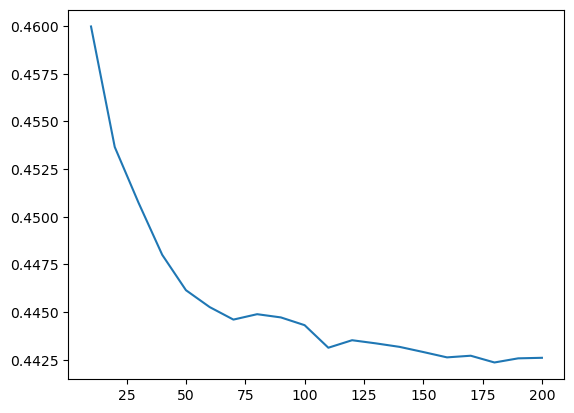

In [ ]:

plt.plot(df_scores.n_estimator, df_scores.rmse)

## Question 4

Let's select the best `max_depth`:

* Try different values of `max_depth`: `[10, 15, 20, 25]`
* For each of these values,
  * try different values of `n_estimators` from 10 till 200 (with step 10)
  * calculate the mean RMSE 
* Fix the random seed: `random_state=1`

In [68]:
scores = []
parameters =  np.linspace(start = 10, stop = 200, num = 20, dtype=int)
for depth in [10, 15, 20, 25]:
    for param in parameters:
        dt = RandomForestRegressor(n_estimators=param, max_depth = depth, random_state=1)
        dt.fit(X_train, y_train)
        y_pred = dt.predict(X_val)
        rmse = root_mean_squared_error(y_val, y_pred)
        scores.append((depth, param, rmse))

In [ ]:
columns = ['depth', 'n_estimator', 'rmse']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores.sort_values(by=['rmse'], ascending=True).head(5)


,depth,n_estimator,rmse
17,10,180,0.439837
19,10,200,0.439942
18,10,190,0.439982
15,10,160,0.439997
14,10,150,0.440128


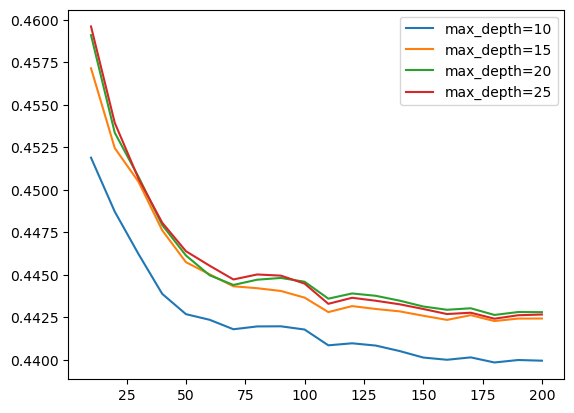

In [ ]:
for d in [10, 15, 20, 25]:
    df_subset = df_scores[df_scores.depth == d]
    
    plt.plot(df_subset.n_estimator, df_subset.rmse,
             label='max_depth=%d' % d)

plt.legend()

# Question 5

We can extract feature importance information from tree-based models. 

At each step of the decision tree learning algorithm, it finds the best split. 
When doing it, we can calculate "gain" - the reduction in impurity before and after the split. 
This gain is quite useful in understanding what are the important features for tree-based models.

In Scikit-Learn, tree-based models contain this information in the
[`feature_importances_`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor.feature_importances_)
field. 

For this homework question, we'll find the most important feature:

* Train the model with these parameters:
  * `n_estimators=10`,
  * `max_depth=20`,
  * `random_state=1`,
  * `n_jobs=-1` (optional)
* Get the feature importance information from this model

In [ ]:
dt = RandomForestRegressor(n_estimators=10, max_depth = 20, random_state=1)
dt.fit(X_train, y_train)

,n_estimators,10
,criterion,'squared_error'
,max_depth,20
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [ ]:

# The higher, the more important the feature.

df_features = pd.DataFrame(
    data = dt.feature_importances_, 
    index = dv.feature_names_, 
    columns = ['importance']).sort_values(by=['importance'], ascending=True)
df_features.filter(items=['vehicle_weight', 'horsepower', 'acceleration', 'engine_displacement'], axis=0)

,importance
vehicle_weight,0.959162
horsepower,0.016040
acceleration,0.011471
engine_displacement,0.003269


In [109]:
dt.feature_importances_?

Type:        property
String form: <property object at 0x758838fe3e70>
Docstring:  
The impurity-based feature importances.

The higher, the more important the feature.
The importance of a feature is computed as the (normalized)
total reduction of the criterion brought by that feature.  It is also
known as the Gini importance.

high cardinality features (many unique values). See
:func:`sklearn.inspection.permutation_importance` as an alternative.

Returns
-------
feature_importances_ : ndarray of shape (n_features,)
    The values of this array sum to 1, unless all trees are single node
    trees consisting of only the root node, in which case it will be an
    array of zeros.

## Question 6

Now let's train an XGBoost model! For this question, we'll tune the `eta` parameter:

* Install XGBoost
* Create DMatrix for train and validation
* Create a watchlist
* Train a model with these parameters for 100 rounds:

```
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```

Now change `eta` from `0.3` to `0.1`.

Which eta leads to the best RMSE score on the validation dataset?

In [ ]:
features = list(dv.get_feature_names_out())
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

# capture model progress over training
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [118]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
}
evals_result_eta_03 = {}
model = xgb.train(
    xgb_params, dtrain, num_boost_round=100, 
    evals=watchlist, evals_result = evals_result_eta_03,
    verbose_eval=False)


In [ ]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
}
evals_result_eta_01 = {}
model = xgb.train(
    xgb_params, dtrain, num_boost_round=100, 
    evals=watchlist, evals_result = evals_result_eta_01,
    verbose_eval=False)


In [129]:
# Access the evaluation results
def parse_xgb_output(output):

    columns = ['train', 'val']

    df_score_train = pd.DataFrame(output['train']['rmse'])
    df_score_val = pd.DataFrame(output['val']['rmse'])
    
    df_score = pd.concat([df_score_train, df_score_val], axis = 1,)
    df_score.columns = columns

    df_score['num_iter'] = df_score.reset_index().index + 1
    return df_score

In [132]:
df_score_03 = parse_xgb_output(evals_result_eta_03)
df_score_03.sort_values(by=['val'], ascending=True).head()


,train,val,num_iter
14,0.350252,0.433486,15
15,0.346656,0.433618,16
19,0.337092,0.433742,20
20,0.335531,0.433764,21
16,0.344591,0.433777,17


In [133]:
df_score_01 = parse_xgb_output(evals_result_eta_01)
df_score_01.sort_values(by=['val'], ascending=True).head()

,train,val,num_iter
56,0.333864,0.424263,57
57,0.332922,0.424290,58
58,0.331963,0.424385,59
61,0.329528,0.424443,62
54,0.335599,0.424478,55
